In [6]:
%reload_ext sql
%config SqlMagic.autocommit=False
%config SqlMagic.autolimit=0
%config SqlMagic.autopandas=True
%config SqlMagic.displaylimit=200
%sql trino://localhost:9090/cuebiq/

import pandas as pd
import yaml
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
from pyhive import trino
import pydeck as pdk
from typing import List
import json
import copy
import itertools
from pyquadkey2 import quadkey
from pyquadkey2.quadkey import TileAnchor, QuadKey
from h3 import h3
import seaborn as sns
from keplergl import KeplerGl
from datetime import datetime, timedelta
import math
import pickle

os.environ['MAPBOX_API_KEY'] = "INSERT YOUR MAPBOX TOKEN HERE"
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import warnings
warnings.filterwarnings('ignore')

In [7]:
# SQL engine
from trino.dbapi import connect 
from sqlalchemy import create_engine

class TrinoEngine():
    def __init__(self):
        conn = connect(
            host="localhost",
            port=9090,
            catalog="cuebiq"
        )
        self.cur = conn.cursor()
        self.engine = create_engine("trino://localhost:9090/cuebiq/")
    
    def execute_statement(self, query:str) -> list:
        """
        Create and drop statements.
        """
        self.cur.execute(query)
        return self.cur.fetchall()
    
    def read_sql(self, query:str) -> pd.DataFrame: 
        """
        Select and insert into operations.
        """
        return pd.read_sql(query, self.engine)

sql_engine = TrinoEngine()

In [8]:
def compute_scaled_entropy(row,col1,col2,col3,col4,col5,col6):
    sum_nominator = 0
    for item in [row[col1],row[col2],row[col3],row[col4],row[col5],row[col6]]:
        if item != 0:
            sum_nominator += item*(np.log(1/item))
    row['scaled_entropy'] = sum_nominator/np.log(6)
    return row

def identify_max_col(row,col1,col2,col3,col4,col5,col6):
    dominant = max([row[col1],row[col2],row[col3],row[col4],row[col5],row[col6]])
    if dominant == row[col1]: row['dominant_race'] = col1
    if dominant == row[col2]: row['dominant_race'] = col2
    if dominant == row[col3]: row['dominant_race'] = col3
    if dominant == row[col4]: row['dominant_race'] = col4
    if dominant == row[col5]: row['dominant_race'] = col5
    if dominant == row[col6]: row['dominant_race'] = col6
    return row

def extract_dominant_group(df):
    df.loc[df['scaled_entropy']<=0.3707,'class'] = 'low diversity'
    df.loc[df['R_White']>=0.8,'class'] = 'low diversity'
    df.loc[df['R_HispanicLatinx']>=0.8,'class'] = 'low diversity'
    df.loc[df['R_AfricanAmerican']>=0.8,'class'] = 'low diversity'
    df.loc[df['R_AmericanIndianAlaska']>=0.8,'class'] = 'low diversity'
    df.loc[df['R_Asian']>=0.8,'class'] = 'low diversity'
    df.loc[df['R_Other']>=0.8,'class'] = 'low diversity'

    df.loc[(df['scaled_entropy']>=0.7414)&(df['R_White']<0.45)
                             &(df['R_HispanicLatinx']<0.45)&(df['R_AfricanAmerican']<0.45)
                             &(df['R_AmericanIndianAlaska']<0.45)&(df['R_Asian']<0.45)
                             &(df['R_Other']<0.45)
                             ,'class'] = 'high diversity'

    df['class'] = df['class'].fillna('moderate diversity')
    print(df['class'].value_counts())
    
    df = df.apply(lambda x:identify_max_col(x,'R_White','R_HispanicLatinx','R_AfricanAmerican','R_AmericanIndianAlaska','R_Asian','R_Other'), axis=1)
    
    df['class_dominant'] = df['dominant_race'] + '_' + df['class']
    df.loc[df['class']=='high diversity','class_dominant'] = 'high diversity'
    print(df.class_dominant.value_counts())
    return df

In [9]:
# %%time
# sql_engine.read_sql(f"desc cuebiq.paas_cda_pe_v3.poi")

In [10]:
df_poi_cat = pd.read_pickle("../output/LA_POI_category.pkl") # all POI in LA
# df_indi_home_loc_race = pd.read_pickle("./output/CA_Individual_race_composition.pkl")
# print(df_indi_home_loc_race.shape[0]) # all cubiq individuals who live in California: 1600238
# df_indi_home_loc_race.head(1)

In [11]:
# Greater LA: Ventura County, San Bernardino County, Riverside County, Los Angeles County, Orange County
df_indi_home_loc_race = pd.read_pickle("../output/GreaterLA_Individual_race_composition_20190301.pkl")
print(df_indi_home_loc_race.shape[0]) # these are Greater LA local residents: 751552 (2022 mobile phone data)
df_indi_home_loc_race.head(1)

525248


cuebiq_id          home_block  population    R_White  R_HispanicLatinx  R_AfricanAmerican  R_AmericanIndianAlaska   R_Asian   R_Other  devices    weight
0  1847634951  US.CA.065.044510.2  2497.0      10.597561  16.231707         1.853659           0.341463                0.304878  1.121951  82       30.45122

# 1. diversity measured by proportions of different racial populations

In [58]:
weekday = False#False, True
timeofday = 'evening' #morning,noon,afternoon,evening

# date = ['20220301_20220308','20220309_20220316','20220317_20220323','20220324_20220331']
date = ['20190301_20190308','20190309_20190316','20190317_20190323','20190324_20190331']
# weekendays = [20220305,20220306,20220312,20220313,20220319,20220320,20220326,20220327]
weekendays = [20190302,20190303,20190309,20190310,20190316,20190317,20190323,20190324,20190330,20190331]

option 1: distinguish between weekend and weekdays and the time of the day based on visit's start hour (Morning 5-10, Noon 11-13, Afternoon 14-17, Evening 18-4)

In [59]:
%%time

sum_df_race = pd.DataFrame()
print('weekday:',weekday,',',timeofday,'*'*10)
for d in date:
    df_visit_LA = pd.read_pickle("../output/LA_visit_with_poiCategory"+str(d)+".pkl") # POI visits in LA
    if weekday:#1. select weekdays
        df_visit_LA = df_visit_LA[~df_visit_LA.event_date.isin(weekendays)]        
    else:#2. select weekends
        df_visit_LA = df_visit_LA[df_visit_LA.event_date.isin(weekendays)] 
    df_visit_LA.drop_duplicates(keep='last', inplace=True)
    
    #3. differentiate morning,noon,afternoon,evening
    if timeofday == 'morning':
        df_visit_LA = df_visit_LA[(df_visit_LA.start_hour<=10)&(df_visit_LA.end_hour>=5)]
    elif timeofday == 'noon':
        df_visit_LA = df_visit_LA[(df_visit_LA.start_hour<=13)&(df_visit_LA.end_hour>=11)]
    elif timeofday == 'afternoon':
        df_visit_LA = df_visit_LA[(df_visit_LA.start_hour<=17)&(df_visit_LA.end_hour>=14)]
    elif timeofday == 'evening':
        df_visit_LA = df_visit_LA[(df_visit_LA.start_hour<=24)&(df_visit_LA.end_hour>=18)]
        # df_visit_LA = df_visit_LA[((df_visit_LA.start_hour<=24)&(df_visit_LA.end_hour>=18))|((df_visit_LA.start_hour<=4)&(df_visit_LA.end_hour>=0))]

    print('****',d,'****')
    print('visit records:',df_visit_LA.shape[0])
    print('unique persons:',df_visit_LA.cuebiq_id.unique().shape[0])
    print('unique POIs:',df_visit_LA.place_id.unique().shape[0])
    
    df_visit_LA_race = pd.merge(df_visit_LA, df_indi_home_loc_race, on='cuebiq_id')
    print("---after left join CA race---") # the counts drop because some visits were coming from outside CA/greater LA
    print('visit records:',df_visit_LA_race.shape[0])
    print('unique persons:',df_visit_LA_race.cuebiq_id.unique().shape[0])
    print('unique POIs:',df_visit_LA_race.place_id.unique().shape[0])    

    sub_df_visit_LA_race = df_visit_LA_race[['place_id','R_White','R_HispanicLatinx','R_AfricanAmerican','R_AmericanIndianAlaska','R_Asian','R_Other','weight']]
    sub_df_visit_LA_race = sub_df_visit_LA_race.groupby('place_id').sum().reset_index() # groupby POI id
    sum_df_race = sum_df_race.append(sub_df_visit_LA_race)

weekday: False , evening **********
**** 20190301_20190308 ****
visit records: 81086
unique persons: 44223
unique POIs: 14026
---after left join CA race---
visit records: 75082
unique persons: 40723
unique POIs: 13549
**** 20190309_20190316 ****
visit records: 144680
unique persons: 73405
unique POIs: 17520
---after left join CA race---
visit records: 122791
unique persons: 61322
unique POIs: 16649
**** 20190317_20190323 ****
visit records: 94318
unique persons: 52611
unique POIs: 14944
---after left join CA race---
visit records: 75973
unique persons: 41721
unique POIs: 13821
**** 20190324_20190331 ****
visit records: 134274
unique persons: 69610
unique POIs: 16848
---after left join CA race---
visit records: 103313
unique persons: 52732
unique POIs: 15441
CPU times: user 10.4 s, sys: 1.62 s, total: 12 s
Wall time: 12 s


option 2: distinguish between weekend and weekdays only

In [53]:
# %%time

# weekday = False

# date = ['20220301_20220308','20220309_20220316','20220317_20220323','20220324_20220331']
# weekendays = [20220305,20220306,20220312,20220313,20220319,20220320,20220326,20220327]
# sum_df_race = pd.DataFrame()
# for d in date:
#     df_visit_LA = pd.read_pickle("./output/LA_visit_with_poiCategory"+str(d)+".pkl")
    
#     if weekday:#1. select weekdays
#         df_visit_LA = df_visit_LA[~df_visit_LA.event_date.isin(weekendays)]        
#     else:#2. select weekends
#         df_visit_LA = df_visit_LA[df_visit_LA.event_date.isin(weekendays)] 
#     df_visit_LA.drop_duplicates(keep='last', inplace=True) 

#     print('****',d,'****')
#     print('visit records:',df_visit_LA.shape[0])
#     print('unique persons:',df_visit_LA.cuebiq_id.unique().shape[0])
#     print('unique POIs:',df_visit_LA.place_id.unique().shape[0])
    
#     df_visit_LA_race = pd.merge(df_visit_LA, df_indi_home_loc_race,on='cuebiq_id')  
    
#     print("---after left join CA race---")
#     print('visit records:',df_visit_LA_race.shape[0])
#     print('unique persons:',df_visit_LA_race.cuebiq_id.unique().shape[0])
#     print('unique POIs:',df_visit_LA_race.place_id.unique().shape[0])
    
#     sub_df_visit_LA_race = df_visit_LA_race[['place_id','R_White','R_HispanicLatinx','R_AfricanAmerican','R_AmericanIndianAlaska','R_Asian','R_Other','weight']]
#     sub_df_visit_LA_race = sub_df_visit_LA_race.groupby('place_id').sum().reset_index() # groupby POI id
#     sum_df_race = sum_df_race.append(sub_df_visit_LA_race)

In [8]:
# %%time
# ## this code snippet is only for descriptive statistics and no need to run in the future

# weekday = False
# date = ['20220301_20220308','20220309_20220316','20220317_20220323','20220324_20220331']
# weekendays = [20220305,20220306,20220312,20220313,20220319,20220320,20220326,20220327]
# sum_df_race = pd.DataFrame()
# for d in date:
#     df_visit_LA = pd.read_pickle("./output/LA_visit_with_poiCategory"+str(d)+".pkl")
#     if weekday:#1. select weekdays
#         df_visit_LA = df_visit_LA[~df_visit_LA.event_date.isin(weekendays)]        
#     else:#2. select weekends
#         df_visit_LA = df_visit_LA[df_visit_LA.event_date.isin(weekendays)] 
#     df_visit_LA.drop_duplicates(keep='last', inplace=True) 
#     df_visit_LA_race = pd.merge(df_visit_LA, df_indi_home_loc_race,on='cuebiq_id')  
#     sum_df_race = sum_df_race.append(df_visit_LA_race)
# print('total visit records:',sum_df_race.shape[0])
# print('total unique persons:',sum_df_race.cuebiq_id.unique().shape[0])
# print('total unique POIs:',sum_df_race.place_id.unique().shape[0])    

total visit records: 2046923
total unique persons: 239447
total unique POIs: 43996
CPU times: user 22.7 s, sys: 3.23 s, total: 25.9 s
Wall time: 25.9 s


option 3: merge whole month visit (voided)

In [9]:
# %%time
# date = ['20220301_20220308','20220309_20220316','20220317_20220323','20220324_20220331']
# #weekend days: 20220305,20220306,20220312,20220313,20220319,20220320,20220326,20220327
# sum_df_race = pd.DataFrame()
# for d in date:
#     df_visit_LA = pd.read_pickle("./output/LA_visit_with_poiCategory"+str(d)+".pkl")
#     print('****',d,'****')
#     print('visit records:',df_visit_LA.shape[0])
#     print('unique persons:',df_visit_LA.cuebiq_id.unique().shape[0])
#     print('unique POIs:',df_visit_LA.place_id.unique().shape[0])
#     df_visit_LA_race = pd.merge(df_visit_LA, df_indi_home_loc_race,on='cuebiq_id')  
    
#     sub_df_visit_LA_race = df_visit_LA_race[['place_id','R_White','R_HispanicLatinx','R_AfricanAmerican','R_AmericanIndianAlaska','R_Asian','R_Other','weight']]
#     sub_df_visit_LA_race = sub_df_visit_LA_race.groupby('place_id').sum().reset_index() # groupby POI id
#     print(sub_df_visit_LA_race.shape[0])
#     sum_df_race = sum_df_race.append(sub_df_visit_LA_race)
#     print(sum_df_race.shape[0])

In [60]:
sum_df_race = sum_df_race.groupby('place_id').sum().reset_index()
print('unique POIs:',sum_df_race.shape[0])
sum_df_race = sum_df_race[sum_df_race['weight']>5] #here weight correspond to weighted visit population at each POI
print('unique POIs:',sum_df_race.shape[0])

unique POIs: 22178
unique POIs: 22178


In [61]:
%%time
#compute entropy and identify dominant group
sum_df_race['R_White'] = sum_df_race['R_White']/sum_df_race['weight']
sum_df_race['R_AfricanAmerican'] = sum_df_race['R_AfricanAmerican']/sum_df_race['weight']
sum_df_race['R_AmericanIndianAlaska'] = sum_df_race['R_AmericanIndianAlaska']/sum_df_race['weight']
sum_df_race['R_Asian'] = sum_df_race['R_Asian']/sum_df_race['weight']
sum_df_race['R_HispanicLatinx'] = sum_df_race['R_HispanicLatinx']/sum_df_race['weight']
sum_df_race['R_Other'] = sum_df_race['R_Other']/sum_df_race['weight']

sum_df_race = sum_df_race.apply(lambda x:compute_scaled_entropy(x,'R_White','R_AfricanAmerican','R_HispanicLatinx','R_AmericanIndianAlaska','R_Asian','R_Other'), axis=1)
sum_df_race = sum_df_race[sum_df_race['scaled_entropy'].notna()]
sum_df_race = extract_dominant_group(sum_df_race)
print(sum_df_race.shape[0])
sum_df_race.head()

moderate diversity    16312
high diversity        3534 
low diversity         2332 
Name: class, dtype: int64
R_HispanicLatinx_moderate diversity     9538
R_White_moderate diversity              5571
high diversity                          3534
R_HispanicLatinx_low diversity          2095
R_Asian_moderate diversity              907 
R_AfricanAmerican_moderate diversity    294 
R_White_low diversity                   182 
R_Asian_low diversity                   38  
R_AfricanAmerican_low diversity         17  
R_Other_moderate diversity              2   
Name: class_dominant, dtype: int64
22178
CPU times: user 25.4 s, sys: 11.6 ms, total: 25.4 s
Wall time: 25.4 s


place_id   R_White  R_HispanicLatinx  R_AfricanAmerican  R_AmericanIndianAlaska   R_Asian   R_Other      weight  scaled_entropy               class     dominant_race              class_dominant
0  25033527.0  0.049251  0.341006          0.000000           0.000000                0.417024  0.192719  51.888889   0.668175        moderate diversity  R_Asian           R_Asian_moderate diversity
1  25033543.0  0.653545  0.108054          0.013055           0.001958                0.170516  0.052872  105.655782  0.582854        moderate diversity  R_White           R_White_moderate diversity
2  25033570.0  0.395486  0.174956          0.041486           0.000000                0.342111  0.045962  122.322587  0.732462        moderate diversity  R_White           R_White_moderate diversity
3  25033573.0  0.326521  0.315934          0.050372           0.011415                0.213802  0.081956  179.945254  0.818149        high diversity      R_White           high diversity            
4  25033586.0  0.307159  0.307946          0.036870           0.000000                0.285937  0.062087  38.710069   0.768799        high diversity      R_HispanicLatinx  high diversity

In [62]:
sub_df_visit_LA_race_poi = pd.merge(sum_df_race,df_poi_cat[['place_id','poi_lat','poi_lng','brand_name','sic_code','sic_name']],on='place_id')
# sub_df_visit_LA_race_poi = sub_df_visit_LA_race_poi[sub_df_visit_LA_race_poi['class_dominant']!='R_Other_moderate diversity']
print('rows:',sub_df_visit_LA_race_poi.shape[0]) #36053
print('unique POIs:',sub_df_visit_LA_race_poi.place_id.unique().shape[0]) #36053
sub_df_visit_LA_race_poi.head()

rows: 22178
unique POIs: 22178


place_id   R_White  R_HispanicLatinx  R_AfricanAmerican  R_AmericanIndianAlaska   R_Asian   R_Other      weight  scaled_entropy               class     dominant_race              class_dominant    poi_lat     poi_lng brand_name  sic_code                              sic_name
0  25033527.0  0.049251  0.341006          0.000000           0.000000                0.417024  0.192719  51.888889   0.668175        moderate diversity  R_Asian           R_Asian_moderate diversity  34.033524 -118.272158  Porsche    5511.0    Motor Vehicle Dealers (New and Used)
1  25033543.0  0.653545  0.108054          0.013055           0.001958                0.170516  0.052872  105.655782  0.582854        moderate diversity  R_White           R_White_moderate diversity  34.168174 -118.595764  Porsche    5511.0    Motor Vehicle Dealers (New and Used)
2  25033570.0  0.395486  0.174956          0.041486           0.000000                0.342111  0.045962  122.322587  0.732462        moderate diversity  R_White           R_White_moderate diversity  34.146216 -118.157151  Porsche    5511.0    Motor Vehicle Dealers (New and Used)
3  25033573.0  0.326521  0.315934          0.050372           0.011415                0.213802  0.081956  179.945254  0.818149        high diversity      R_White           high diversity              33.923604 -118.103156  Porsche    5511.0    Motor Vehicle Dealers (New and Used)
4  25033586.0  0.307159  0.307946          0.036870           0.000000                0.285937  0.062087  38.710069   0.768799        high diversity      R_HispanicLatinx  high diversity              33.790930 -118.143355  Porsche    5511.0    Motor Vehicle Dealers (New and Used)

In [63]:
##for option 1:
if weekday:
    outputpath = "../output/onlyGreaterLAresidents/LA_POI_diversity_201903_weekday_"+timeofday+".pkl"
else:
    outputpath = "../output/onlyGreaterLAresidents/LA_POI_diversity_201903_weekend_"+timeofday+".pkl"
sub_df_visit_LA_race_poi.to_pickle(outputpath)

##for option 2:
# if weekday:
#     outputpath = "../output/onlyGreaterLAresidents/LA_POI_diversity_202203_weekday.pkl"
# else:
#     outputpath = "../output/onlyGreaterLAresidents/LA_POI_diversity_202203_weekend.pkl"
# sub_df_visit_LA_race_poi.to_pickle(outputpath)

# sub_df_visit_LA_race_poi = pd.read_pickle("../output/LA_POI_diversity_202203.pkl")  
## pd.crosstab(sub_df_visit_LA_race_poi.class_dominant, sub_df_visit_LA_race_poi.sic_name)

# 2. diversity measured by proportion of dwell time at POI by different racial groups

In [99]:
weekday = False
timeofday = 'evening' #morning,noon,afternoon,evening

In [100]:
%%time
date = ['20220301_20220308','20220309_20220316','20220317_20220323','20220324_20220331']
weekendays = [20220305,20220306,20220312,20220313,20220319,20220320,20220326,20220327]

df_duration_byrace = pd.DataFrame()
print('weekday:',weekday,',',timeofday,'*'*10)
for d in date:
    df_visit_LA = pd.read_pickle("./output/LA_visit_with_poiCategory"+str(d)+".pkl")
    
    if weekday:#1. select weekdays
        df_visit_LA = df_visit_LA[~df_visit_LA.event_date.isin(weekendays)]        
    else:#2.. select weekends
        df_visit_LA = df_visit_LA[df_visit_LA.event_date.isin(weekendays)] 
    df_visit_LA.drop_duplicates(keep='last', inplace=True)
    
    #3. differentiate morning,noon,afternoon,evening
    if timeofday == 'morning':
        df_visit_LA = df_visit_LA[(df_visit_LA.start_hour<=10)&(df_visit_LA.end_hour>=5)]
    elif timeofday == 'noon':
        df_visit_LA = df_visit_LA[(df_visit_LA.start_hour<=13)&(df_visit_LA.end_hour>=11)]
    elif timeofday == 'afternoon':
        df_visit_LA = df_visit_LA[(df_visit_LA.start_hour<=17)&(df_visit_LA.end_hour>=14)]
    elif timeofday == 'evening':
        df_visit_LA = df_visit_LA[((df_visit_LA.start_hour<=24)&(df_visit_LA.end_hour>=18))|((df_visit_LA.start_hour<=4)&(df_visit_LA.end_hour>=0))]

    print('****',d,'****')
    print('visit records:',df_visit_LA.shape[0])
    print('unique persons:',df_visit_LA.cuebiq_id.unique().shape[0])
    print('unique POIs:',df_visit_LA.place_id.unique().shape[0])
    
    df_visit_LA_race = pd.merge(df_visit_LA, df_indi_home_loc_race,on='cuebiq_id')  
    print("---after left join CA race---")
    print('visit records:',df_visit_LA_race.shape[0])
    print('unique persons:',df_visit_LA_race.cuebiq_id.unique().shape[0])
    print('unique POIs:',df_visit_LA_race.place_id.unique().shape[0])    
    
    sub_df_visit_LA_race = df_visit_LA_race[['place_id','dwell_time_minutes','R_White','R_HispanicLatinx','R_AfricanAmerican','R_AmericanIndianAlaska','R_Asian','R_Other']]
    sub_df_visit_LA_race['R_White'] = sub_df_visit_LA_race['R_White']*sub_df_visit_LA_race['dwell_time_minutes']
    sub_df_visit_LA_race['R_HispanicLatinx'] = sub_df_visit_LA_race['R_HispanicLatinx']*sub_df_visit_LA_race['dwell_time_minutes']
    sub_df_visit_LA_race['R_AfricanAmerican'] = sub_df_visit_LA_race['R_AfricanAmerican']*sub_df_visit_LA_race['dwell_time_minutes']
    sub_df_visit_LA_race['R_AmericanIndianAlaska'] = sub_df_visit_LA_race['R_AmericanIndianAlaska']*sub_df_visit_LA_race['dwell_time_minutes']
    sub_df_visit_LA_race['R_Asian'] = sub_df_visit_LA_race['R_Asian']*sub_df_visit_LA_race['dwell_time_minutes']
    sub_df_visit_LA_race['R_Other'] = sub_df_visit_LA_race['R_Other']*sub_df_visit_LA_race['dwell_time_minutes']
    
    sub_df_visit_LA_race = sub_df_visit_LA_race.groupby('place_id').sum().reset_index() # groupby POI id
    sub_df_visit_LA_race.drop(['dwell_time_minutes'], inplace=True, axis=1)
    sub_df_visit_LA_race['total_duration'] = sub_df_visit_LA_race['R_White']+sub_df_visit_LA_race['R_HispanicLatinx']+sub_df_visit_LA_race['R_AfricanAmerican']+sub_df_visit_LA_race['R_AmericanIndianAlaska']+sub_df_visit_LA_race['R_Asian']+sub_df_visit_LA_race['R_Other']
    df_duration_byrace = df_duration_byrace.append(sub_df_visit_LA_race)

weekday: False , evening **********
**** 20220301_20220308 ****
visit records: 148399
unique persons: 63858
unique POIs: 24962
---after left join CA race---
visit records: 131984
unique persons: 56374
unique POIs: 24119
**** 20220309_20220316 ****
visit records: 167767
unique persons: 72272
unique POIs: 26078
---after left join CA race---
visit records: 138212
unique persons: 58841
unique POIs: 24689
**** 20220317_20220323 ****
visit records: 170964
unique persons: 72946
unique POIs: 26284
---after left join CA race---
visit records: 125651
unique persons: 52782
unique POIs: 24096
**** 20220324_20220331 ****
visit records: 162983
unique persons: 69949
unique POIs: 26175
---after left join CA race---
visit records: 116174
unique persons: 49186
unique POIs: 23577
CPU times: user 19.5 s, sys: 3.45 s, total: 22.9 s
Wall time: 22.9 s


In [101]:
%%time
df_duration_byrace = df_duration_byrace.groupby('place_id').sum().reset_index()
print('unique POIs:',df_duration_byrace.shape[0])
df_duration_byrace = df_duration_byrace[df_duration_byrace['total_duration']>5] #total_duration is the weighted total activity duration by all visitors at each POI
print('unique POIs:',df_duration_byrace.shape[0])


df_duration_byrace['R_White'] = df_duration_byrace['R_White']/df_duration_byrace['total_duration']
df_duration_byrace['R_AfricanAmerican'] = df_duration_byrace['R_AfricanAmerican']/df_duration_byrace['total_duration']
df_duration_byrace['R_AmericanIndianAlaska'] = df_duration_byrace['R_AmericanIndianAlaska']/df_duration_byrace['total_duration']
df_duration_byrace['R_Asian'] = df_duration_byrace['R_Asian']/df_duration_byrace['total_duration']
df_duration_byrace['R_HispanicLatinx'] = df_duration_byrace['R_HispanicLatinx']/df_duration_byrace['total_duration']
df_duration_byrace['R_Other'] = df_duration_byrace['R_Other']/df_duration_byrace['total_duration']

df_duration_byrace = df_duration_byrace.apply(lambda x:compute_scaled_entropy(x,'R_White','R_AfricanAmerican','R_HispanicLatinx','R_AmericanIndianAlaska','R_Asian','R_Other'), axis=1)
df_duration_byrace = df_duration_byrace[df_duration_byrace['scaled_entropy'].notna()]
df_duration_byrace = extract_dominant_group(df_duration_byrace)
print(df_duration_byrace.shape[0])
df_duration_byrace.head()

unique POIs: 33546
unique POIs: 33546
moderate diversity    24837
high diversity        4979 
low diversity         3730 
Name: class, dtype: int64
R_HispanicLatinx_moderate diversity     15472
R_White_moderate diversity              7767 
high diversity                          4979 
R_HispanicLatinx_low diversity          3381 
R_Asian_moderate diversity              1215 
R_AfricanAmerican_moderate diversity    381  
R_White_low diversity                   295  
R_Asian_low diversity                   31   
R_AfricanAmerican_low diversity         23   
R_Other_moderate diversity              2    
Name: class_dominant, dtype: int64
33546
CPU times: user 38.9 s, sys: 31.3 ms, total: 38.9 s
Wall time: 38.9 s


place_id   R_White  R_HispanicLatinx  R_AfricanAmerican  R_AmericanIndianAlaska   R_Asian   R_Other  total_duration  scaled_entropy               class     dominant_race                       class_dominant
0  25033527.0  0.042534  0.515117          0.392637           0.002455                0.016887  0.030370  20170.947396    0.576455        moderate diversity  R_HispanicLatinx  R_HispanicLatinx_moderate diversity
1  25033543.0  0.234384  0.237928          0.050881           0.000000                0.416945  0.059862  710.189318      0.762654        high diversity      R_Asian           high diversity                     
2  25033570.0  0.332564  0.512702          0.010008           0.000000                0.130870  0.013857  1477.448485     0.602841        moderate diversity  R_HispanicLatinx  R_HispanicLatinx_moderate diversity
3  25033573.0  0.473216  0.248087          0.044680           0.003456                0.131326  0.099235  2263.356881     0.755800        moderate diversity  R_White           R_White_moderate diversity         
4  25033658.0  0.116337  0.883663          0.000000           0.000000                0.000000  0.000000  1948.269388     0.200675        low diversity       R_HispanicLatinx  R_HispanicLatinx_low diversity

In [102]:
df_duration_byrace_diversity = pd.merge(df_duration_byrace,df_poi_cat[['place_id','poi_lat','poi_lng','brand_name','sic_code','sic_name']],on='place_id',how='left')
print(df_duration_byrace_diversity.shape[0])
df_duration_byrace_diversity=df_duration_byrace_diversity[df_duration_byrace_diversity['class_dominant']!='R_Other_moderate diversity']
print(df_duration_byrace_diversity.shape[0])
# df_duration_byrace_diversity.head()

33546
33544


In [103]:
# if weekday:
#     outputpath = "./output/LA_POI_durationbased_diversity_202203_weekday_"+timeofday+".pkl"
# else:
#     outputpath = "./output/LA_POI_durationbased_diversity_202203_weekend_"+timeofday+".pkl"
if weekday:
    outputpath = "./output/onlyGreaterLAresidents/LA_POI_durationbased_diversity_202203_weekday_"+timeofday+".pkl"
else:
    outputpath = "./output/onlyGreaterLAresidents/LA_POI_durationbased_diversity_202203_weekend_"+timeofday+".pkl"    
    
df_duration_byrace_diversity.to_pickle(outputpath)
# df_duration_byrace_diversity.to_pickle("./output/LA_POI_durationbased_diversity_202203.pkl")
# df_duration_byrace_diversity.to_pickle("./output/LA_POI_durationbased_diversity_202203_weekend.pkl")
# df_duration_byrace_diversity.to_pickle("./output/LA_POI_durationbased_diversity_202203_weekday.pkl")

# Comparison between two types of diversity indicators

In [17]:
sub_df_visit_LA_race_poi = pd.read_pickle("./output/LA_POI_diversity_202203_weekday.pkl")  
df_duration_byrace_diversity = pd.read_pickle("./output/LA_POI_durationbased_diversity_202203_weekday.pkl")
print(sub_df_visit_LA_race_poi.shape[0],df_duration_byrace_diversity.shape[0])

48731 48561


In [18]:
df_diversity1 = sub_df_visit_LA_race_poi[['place_id','scaled_entropy','class_dominant']]
df_diversity2 = df_duration_byrace_diversity[['place_id','scaled_entropy','class_dominant','poi_lat','poi_lng','brand_name','sic_code','sic_name']]
df_diversity2.rename(columns={'scaled_entropy': 'dur_scaled_entropy','class_dominant':'dur_class_dominant'}, inplace=True)
print(df_diversity1.shape[0],df_diversity2.shape[0])
df_diversity1 = pd.merge(df_diversity1,df_diversity2,on='place_id',how='left')
print(df_diversity1.shape[0])

48731 48561
48731


In [19]:
def plot_hist(df,title):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    df.dur_scaled_entropy.hist(ax=ax,bins=50,alpha = 0.5,legend=True)
    df.scaled_entropy.hist(ax=ax,bins=50,alpha = 0.5,legend=True)
    plt.title(title)
    plt.show()

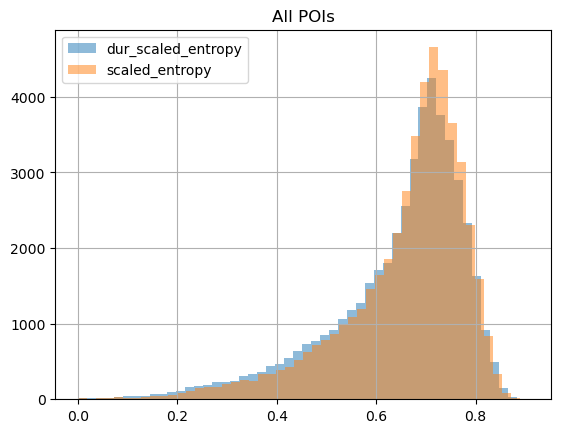

In [20]:
plot_hist(df_diversity1,'All POIs')

In [11]:
# #5812.0 Eating Places,  5411.0 Grocery Stores, 7991.0 Physical Fitness Facilities
# #7231.0 Beauty Shops, 6021.0 National Commercial Banks, 7011.0 Hotels and Motels 5311.0
# plot_hist(df_diversity1[df_diversity1.sic_code==5812],'Restaurant')
# plot_hist(df_diversity1[df_diversity1.sic_code==5411],'Grocery Store')
# plot_hist(df_diversity1[df_diversity1.sic_code==7991],'Physical Fitness Facilities')

In [22]:
df_diversity1['equal'] = df_diversity1['class_dominant'] == df_diversity1['dur_class_dominant']
print('total POI:',df_diversity1.shape[0])
print('POIs that show different dominant diversity type:',df_diversity1[df_diversity1['equal']!=True].shape[0])
print(df_diversity1[df_diversity1['equal']!=True].shape[0]/df_diversity1.shape[0])
display(df_diversity1[df_diversity1['equal']!=True].head())

total POI: 48731
POIs that show different dominant diversity type: 8174
0.167737169358314


place_id  scaled_entropy                       class_dominant  dur_scaled_entropy                   dur_class_dominant    poi_lat     poi_lng      brand_name  sic_code                                            sic_name  equal
2   25033570.0  0.789457        high diversity                       0.739927            R_HispanicLatinx_moderate diversity  34.146588 -118.157044  Porsche         5511.0    Motor Vehicle Dealers (New and Used)                False
4   25033586.0  0.566989        R_HispanicLatinx_moderate diversity  0.257862            R_HispanicLatinx_low diversity       33.790930 -118.143355  Porsche         5511.0    Motor Vehicle Dealers (New and Used)                False
15  25034318.0  0.741524        high diversity                       0.672182            R_Asian_moderate diversity           34.145371 -118.136474  Charles Schwab  6211.0    Security Brokers, Dealers, and Flotation Companies  False
19  25034767.0  0.606181        R_HispanicLatinx_moderate diversity  0.671381            R_White_moderate diversity           34.421464 -118.558355  MINI            5511.0    Motor Vehicle Dealers (New and Used)                False
27  25036870.0  0.744896        high diversity                       0.741694            R_Asian_moderate diversity           34.001919 -117.808947  Crunch Fitness  7991.0    Physical Fitness Facilities                         False

In [25]:
df_diversity1['diff_entropy'] = (df_diversity1['dur_scaled_entropy'] - df_diversity1['scaled_entropy'])/df_diversity1['scaled_entropy']
# sns.violinplot(data=df_diversity1, x='diff_entropy',orient="h")
df_diversity1['diff_entropy'].hist(bins=100)

# diversity by POI type

In [26]:
test_poi_cat_list = [5812,5411,7991,7231,6021,7011,5311]
#5812.0 Eating Places,  5411.0 Grocery Stores, 7991.0 Physical Fitness Facilities
#7231.0 Beauty Shops, 6021.0 National Commercial Banks, 7011.0 Hotels and Motels 5311.0

In [31]:
plt_data.head()

place_id  scaled_entropy                       class_dominant  dur_scaled_entropy                   dur_class_dominant    poi_lat     poi_lng      brand_name  sic_code                     sic_name  equal  diff_entropy
25  25036812.0  0.589322        R_HispanicLatinx_moderate diversity  0.591954            R_HispanicLatinx_moderate diversity  34.578801 -118.089164  Crunch Fitness  7991.0    Physical Fitness Facilities  True   0.004467    
26  25036818.0  0.806623        high diversity                       0.796996            high diversity                       33.846938 -118.080288  Crunch Fitness  7991.0    Physical Fitness Facilities  True  -0.011936    
27  25036870.0  0.744896        high diversity                       0.741694            R_Asian_moderate diversity           34.001919 -117.808947  Crunch Fitness  7991.0    Physical Fitness Facilities  False -0.004299    
28  25036890.0  0.779440        R_HispanicLatinx_moderate diversity  0.757168            R_HispanicLatinx_moderate diversity  33.861088 -118.126159  Crunch Fitness  7991.0    Physical Fitness Facilities  True  -0.028575    
29  25036901.0  0.694678        R_HispanicLatinx_moderate diversity  0.697541            R_HispanicLatinx_moderate diversity  34.118179 -117.775074  Crunch Fitness  7991.0    Physical Fitness Facilities  True   0.004122

In [32]:
melted_plt_data.head()

sic_name      Value Type  Scaled Entropy
0  Physical Fitness Facilities  scaled_entropy  0.589322      
1  Physical Fitness Facilities  scaled_entropy  0.806623      
2  Physical Fitness Facilities  scaled_entropy  0.744896      
3  Physical Fitness Facilities  scaled_entropy  0.779440      
4  Physical Fitness Facilities  scaled_entropy  0.694678

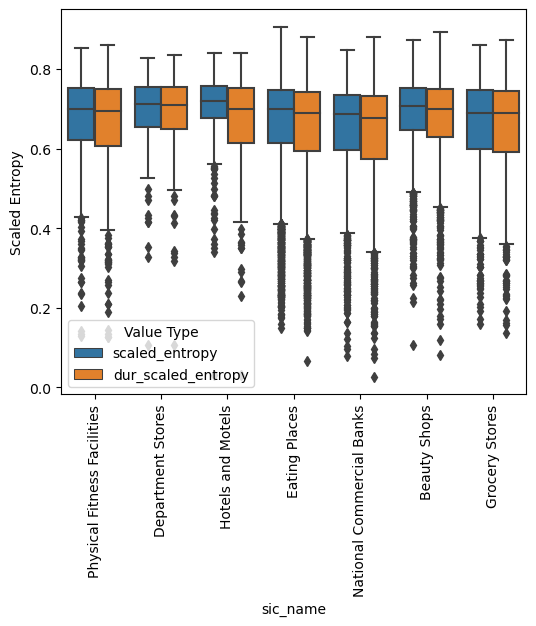

In [27]:
# sns.violinplot(data=sub_df_visit_LA_race2, x='scaled_entropy', y='sic_name',orient="h")
plt_data = df_diversity1[df_diversity1.sic_code.isin(test_poi_cat_list)]
fig, ax = plt.subplots(figsize=(6,5))
melted_plt_data = pd.melt(plt_data, id_vars='sic_name', value_vars=['scaled_entropy', 'dur_scaled_entropy'],
                    var_name='Value Type', value_name='Scaled Entropy')
ax = sns.boxplot(data=melted_plt_data, x='sic_name', y='Scaled Entropy',hue='Value Type', orient="v")
# ax.set_title('Racial diversity based on proportions')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

# Mapping
generate config file: https://kepler.gl/demo/earthquakes

In [3]:
%%time

sub_df_visit_LA_race_poi = pd.read_pickle("./output/LA_POI_diversity_202203_weekday_morning.pkl")  
k3 = KeplerGl(data={'h':sub_df_visit_LA_race_poi}, height=700)
with open('config/visit_poi.py', 'r') as config_file:
    k3.config = json.loads(config_file.read())
k3 

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
CPU times: user 2.3 s, sys: 115 ms, total: 2.42 s
Wall time: 2.42 s


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'hty62yd', 'type': …

In [35]:
# %%time

# sub_df_visit_LA_race_poi = pd.read_pickle("./output/LA_POI_diversity_202203_weekday_afternoon.pkl")  
# k3 = KeplerGl(data={'h':sub_df_visit_LA_race_poi}, height=700) 
# with open('config/visit_poi.py', 'r') as config_file:
#     k3.config = json.loads(config_file.read())
# k3 

In [34]:
# %%time

# sub_df_visit_LA_race_poi = pd.read_pickle("./output/LA_POI_diversity_202203_weekday_evening.pkl")  
# k3 = KeplerGl(data={'h':sub_df_visit_LA_race_poi}, height=700) 
# with open('config/visit_poi.py', 'r') as config_file:
#     k3.config = json.loads(config_file.read())
# k3 

In [11]:
sub_df_visit_LA_race2 = sub_df_visit_LA_race_poi[sub_df_visit_LA_race_poi.sic_code.isin(test_poi_cat_list)]
sub_df_visit_LA_race2.sic_name.unique()

array(['Physical Fitness Facilities', 'Department Stores',
       'Hotels and Motels', 'Eating Places', 'National Commercial Banks',
       'Beauty Shops', 'Grocery Stores'], dtype=object)

In [12]:
%%time
k = KeplerGl(data={'h':sub_df_visit_LA_race2[sub_df_visit_LA_race2['sic_name']=='Eating Places']}, height=700) 
with open('config/visit_poi_restaurant.py', 'r') as config_file:
    k.config = json.loads(config_file.read())
k 

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
CPU times: user 146 ms, sys: 11.6 ms, total: 158 ms
Wall time: 155 ms


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'hty62yd', 'type': …

In [13]:
%%time
k2 = KeplerGl(data={'h':df_duration_byrace_diversity}, height=700) 
with open('config/visit_poi.py', 'r') as config_file:
    k2.config = json.loads(config_file.read())
k2

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
CPU times: user 2.6 s, sys: 67.7 ms, total: 2.67 s
Wall time: 2.67 s


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'hty62yd', 'type': …